In [1]:
import numpy as np
import pandas as pd
import datetime

from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

def drawer(corr):


    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})


In [2]:
df_raw=pd.read_csv('data/master_updated.csv').rename({'Unnamed: 0':'id'},axis=1)
df_raw.head()

,id,accdate,Operator_ID,AccTypeCodeDescr,AccSubTypeCodeDescr,acctype,BAITFISH Code,AccPreventable,Retraining,vehbusno,...,days_employment,freq_absence_one_week,freq_extra_one_week,freq_absence_one_month,freq_extra_one_month,freq_absence_two_month,freq_extra_two_month,accyear,accmonth,accday_
0,0,2016-04-20 11:46:00,1,22,34,2,8,0,0,753,...,16,0.00,0.29,0.00,0.18,0.00,0.18,2016,4,20
1,1,2016-04-20 11:32:00,20,22,33,2,8,0,0,1321,...,16,0.00,0.00,0.12,0.06,0.12,0.06,2016,4,20
2,2,2016-04-25 13:51:00,175,18,25,2,9,1,1,735,...,21,0.29,0.00,0.09,0.00,0.09,0.00,2016,4,25
3,3,2016-04-26 11:10:00,290,3,4,2,14,1,1,728,...,22,0.00,0.14,0.00,0.13,0.00,0.13,2016,4,26
4,4,2016-04-26 16:15:00,146,3,4,2,14,1,1,706,...,22,0.00,0.00,0.00,0.00,0.00,0.00,2016,4,26


In [3]:
df_raw.columns

Index(['id', 'accdate', 'Operator_ID', 'AccTypeCodeDescr',
       'AccSubTypeCodeDescr', 'acctype', 'BAITFISH Code', 'AccPreventable',
       'Retraining', 'vehbusno', 'vehmake', 'vehyear', 'Drv_Age', 'CoDrvSex',
       'Roadway', 'RoadwayLightConditions', 'RoadwayWeather', 'RoadwaySurface',
       'Addr_Type', 'Neighborhood', 'LocAddr1', 'FileNumber', 'Longitude',
       'Latitude', 'SpeedLimitCategory', 'n_accidents_in_0.003',
       'n_accidents_in_0.006', 'n_accidents_in_0.0015',
       'n_accidents_in_0.00075', 'n_accidents_in_0.0005', 'accday', 'acctime',
       'acctimeperiod', 'days_pick_start', 'days_absent', 'days_excused',
       'days_holiday', 'days_late', 'days_medical', 'days_vacation',
       'days_last_accident', 'days_employment', 'freq_absence_one_week',
       'freq_extra_one_week', 'freq_absence_one_month', 'freq_extra_one_month',
       'freq_absence_two_month', 'freq_extra_two_month', 'accyear', 'accmonth',
       'accday_'],
      dtype='object')

# min dist to any bus stop

In [4]:
stop=pd.read_csv('data/bus stop location data.csv')
lat_mask=stop['Latitude'].fillna(0).apply( lambda x: isinstance(x,float) and  x>43 and  x<43.3)
lng_mask=stop['Longitude'].fillna(0).apply( lambda x: isinstance(x,float) and  x>-77.85 and  x<-77.4)
stop=stop.loc[lat_mask & lng_mask, :]
stop

,Stop ID,Stop Name,Longitude,Latitude
0,1,Airport & Brooks,-77.665723,43.130508
1,2,Airport & Service Rd,-77.662297,43.129509
2,3,Airport & Terminal Lower Level,-77.663865,43.127913
3,4,Al Sigl Ctr & Main Entrance,-77.612899,43.125350
4,5,Al Sigl Ctr & Winton Campus,-77.582646,43.084162
...,...,...,...,...
4786,5749,LiDestri,-77.679667,43.184770
4787,5751,Clinton & opp Lac De Ville Plaza,-77.594899,43.121251
4788,5755,Lake & opp Charlotte Harbortown,-77.611755,43.253755
4789,5756,Vertus Charter School,-77.567823,43.154479


In [5]:
def findMinDist(row):
    dist_series=abs(row['Latitude']-stop['Latitude'])+abs(row['Longitude']-stop['Longitude'])
    return min(dist_series)*111000
    
df_raw['meters_from_bus_stop']=df_raw.apply(findMinDist, axis=1)

In [6]:
df_raw['isWeekend']=pd.to_datetime(df_raw.accdate).apply(lambda x: x.weekday()>5)#.describe()
df_raw['vehage']=df_raw.accyear-df_raw.vehyear
df_raw['accyear']=df_raw['accyear']-df_raw['accyear'].min()
df_raw['Latitude'] -= 43
df_raw['Longitude'] -= 77.85
df_raw['days_work_days']= df_raw['days_employment']- df_raw['days_holiday']
def season(month):
    if month in [11,12,1,2]:
        return 'winter'
    elif month in [9,10]:
        return 'fall'
    elif month in [6,7,8]:
        return 'summer'
    else:
        return 'spring'
df_raw['season'] = df_raw['accmonth'].apply(season)

In [7]:
target='AccPreventable'
features=[ 'meters_from_bus_stop', #'Drv_Age', #'vehage', '', 'CoDrvSex'
       #'Longitude','Latitude', 'accmonth', 'accyear''days_work_days','acctimeperiod',
          
       'n_accidents_in_0.006', 'n_accidents_in_0.0015',
        'days_pick_start', 'days_absent', 'days_excused',
     'days_late', 'days_medical', 'days_vacation',
       'days_last_accident',  'freq_absence_one_week',
       'freq_extra_one_week']

categorical_features=['season','Addr_Type','isWeekend','Roadway',   'RoadwaySurface','RoadwayLightConditions', #'RoadwayWeather',
                     'SpeedLimitCategory','Neighborhood']
df=pd.DataFrame(df_raw['id'])
df[target]=df_raw[target]
selected_features=[]
for i in features:
    df[i]=df_raw[i]
    selected_features.append(i)
for i in categorical_features:
    temp_df=pd.get_dummies(df_raw[i],drop_first=False)
    mode_=str(df_raw[i].mode().values[0])
    for col in temp_df.columns:
        if str(col) == mode_:
            #print(col)
            continue
        feature_name=str(i)+'__'+str(col)+'_vs_'+mode_
        df[feature_name]=temp_df[col]
        selected_features.append(feature_name)
selected_features

['meters_from_bus_stop',
 'n_accidents_in_0.006',
 'n_accidents_in_0.0015',
 'days_pick_start',
 'days_absent',
 'days_excused',
 'days_late',
 'days_medical',
 'days_vacation',
 'days_last_accident',
 'freq_absence_one_week',
 'freq_extra_one_week',
 'season__fall_vs_winter',
 'season__spring_vs_winter',
 'season__summer_vs_winter',
 'Addr_Type__1_vs_0',
 'isWeekend__True_vs_False',
 'Roadway__0_vs_5',
 'Roadway__1_vs_5',
 'Roadway__2_vs_5',
 'Roadway__3_vs_5',
 'Roadway__4_vs_5',
 'Roadway__6_vs_5',
 'RoadwaySurface__1_vs_0',
 'RoadwaySurface__2_vs_0',
 'RoadwaySurface__3_vs_0',
 'RoadwaySurface__4_vs_0',
 'RoadwayLightConditions__0_vs_2',
 'RoadwayLightConditions__1_vs_2',
 'RoadwayLightConditions__3_vs_2',
 'RoadwayLightConditions__4_vs_2',
 'SpeedLimitCategory__0_vs_4',
 'SpeedLimitCategory__1_vs_4',
 'SpeedLimitCategory__2_vs_4',
 'SpeedLimitCategory__3_vs_4',
 'SpeedLimitCategory__5_vs_4',
 'SpeedLimitCategory__6_vs_4',
 'Neighborhood__0_vs_25',
 'Neighborhood__1_vs_25',
 'Neigh

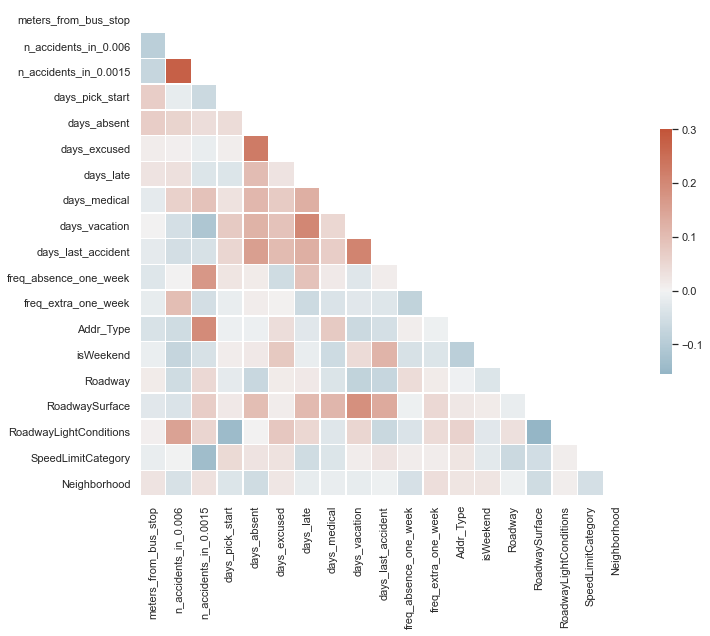

In [8]:
cor=df_raw[features+categorical_features].corr()
correlated=cor.loc[cor.apply(lambda col: any(abs(col) > 0.6)),cor.apply(lambda col: any(abs(col) > 0.6))]#.shape
drawer(correlated)

# Models for feature selection

In [9]:
# check correlation
df.corr()['AccPreventable'][abs(df.corr()['AccPreventable'])>0.1]

AccPreventable           1.000000
n_accidents_in_0.006     0.162120
n_accidents_in_0.0015   -0.102020
Roadway__3_vs_5          0.206966
Name: AccPreventable, dtype: float64

In [10]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X, y = df[selected_features] , df[target]
for i in range(X.shape[1]):
    if variance_inflation_factor(X.values,i)>5:
        print(X.columns[i])

# Deal with colinearity

In [11]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(max_iter=1000000, penalty='none').fit(X, y) #solver='liblinear',
clf.score(X, y)

0.7283702213279678

C:\Users\HuWei\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


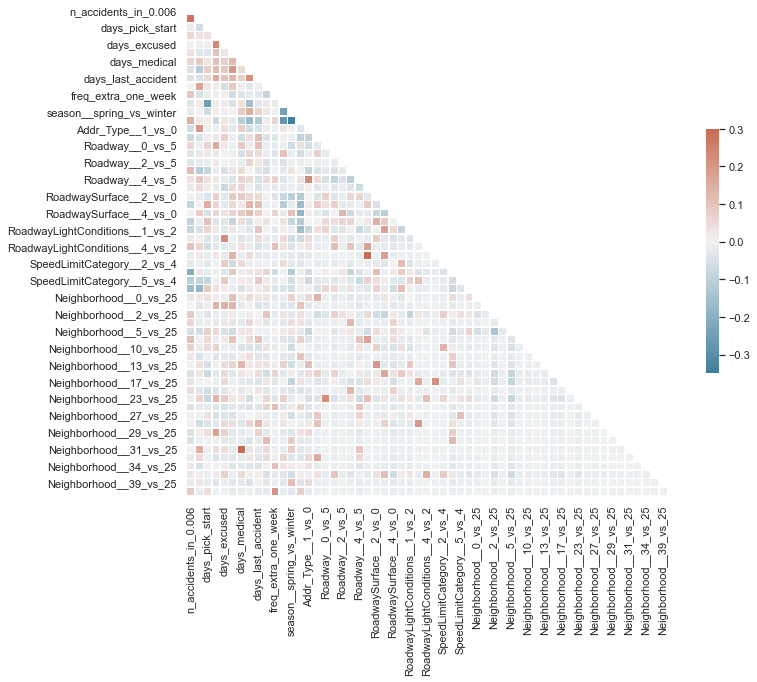

In [12]:
cor=X.corr()
cor.values[[np.arange(cor.shape[0])]*2] = 0
correlated=cor.loc[cor.apply(lambda col: any(abs(col) > 0.1)),cor.apply(lambda col: any(abs(col) > 0.1))]#.shape
drawer(correlated)

In [13]:
correlated

,n_accidents_in_0.006,n_accidents_in_0.0015,days_pick_start,days_absent,days_excused,days_late,days_medical,days_vacation,days_last_accident,freq_absence_one_week,...,Neighborhood__27_vs_25,Neighborhood__28_vs_25,Neighborhood__29_vs_25,Neighborhood__30_vs_25,Neighborhood__31_vs_25,Neighborhood__32_vs_25,Neighborhood__34_vs_25,Neighborhood__36_vs_25,Neighborhood__39_vs_25,Neighborhood__40_vs_25
n_accidents_in_0.006,0.000000,0.278646,-0.015153,0.057450,0.005529,0.035341,0.061810,-0.047228,-0.049185,0.000471,...,-0.002269,-0.006148,-0.049319,-0.047998,-0.000497,-0.018878,0.027360,0.029904,-0.017515,0.083591
n_accidents_in_0.0015,0.278646,0.000000,-0.065060,0.037442,-0.012649,-0.033515,0.090118,-0.112140,-0.044448,0.172384,...,-0.005529,-0.064577,0.010884,-0.010439,0.152704,0.051942,-0.047480,0.010759,0.018582,-0.017689
days_pick_start,-0.015153,-0.065060,0.000000,0.041036,0.007759,-0.032579,0.028501,0.077182,0.051819,0.025031,...,0.034468,-0.038513,0.041855,-0.002187,-0.009748,-0.006307,-0.002922,-0.007984,-0.018080,0.041662
days_absent,0.057450,0.037442,0.041036,0.000000,0.226639,0.102700,0.110257,0.121581,0.156565,0.014092,...,-0.051586,-0.026465,0.182041,-0.012286,0.042072,-0.043685,0.003834,0.019002,-0.042402,-0.009568
days_excused,0.005529,-0.012649,0.007759,0.226639,0.000000,0.026768,0.074307,0.089383,0.103806,-0.057308,...,-0.038572,0.044655,0.070729,-0.029657,0.042575,-0.028620,0.012160,0.073585,-0.012934,-0.005853
days_late,0.035341,-0.033515,-0.032579,0.102700,0.026768,0.000000,0.126886,0.202535,0.126825,0.090183,...,-0.043432,0.042289,-0.031729,-0.022413,-0.022413,-0.031729,-0.038899,-0.013491,-0.031729,-0.022413
days_medical,0.061810,0.090118,0.028501,0.110257,0.074307,0.126886,0.000000,0.050526,0.069337,0.015235,...,-0.014368,-0.035610,-0.025462,-0.017986,0.316430,-0.023795,-0.031216,0.052179,-0.025462,-0.017986
days_vacation,-0.047228,-0.112140,0.077182,0.121581,0.089383,0.202535,0.050526,0.000000,0.210085,-0.029874,...,-0.001725,0.060919,-0.011101,-0.032472,-0.031209,0.028684,-0.036993,0.004359,-0.049545,-0.005315
days_last_accident,-0.049185,-0.044448,0.051819,0.156565,0.103806,0.126825,0.069337,0.210085,0.000000,0.008833,...,0.009148,0.126319,0.073039,-0.027214,-0.027214,-0.038526,-0.045024,0.014559,0.003857,-0.027214
freq_absence_one_week,0.000471,0.172384,0.025031,0.014092,-0.057308,0.090183,0.015235,-0.029874,0.008833,0.000000,...,-0.016461,0.030065,-0.031442,0.124015,0.052185,0.046637,0.004491,-0.050817,-0.031442,-0.022211


28.849254263424058

In [215]:
import statsmodels.api as sm
sm_model = sm.Logit(y, sm.add_constant(X)).fit(disp=0)#, maxiter=10000)
print(sm_model.pvalues)
sm_model.summary()

const                     0.681655
meters_from_bus_stop      0.565625
n_accidents_in_0.006      0.000947
n_accidents_in_0.0015     0.002083
days_pick_start           0.175126
                            ...   
Neighborhood__37_vs_25    0.142645
Neighborhood__39_vs_25    0.996898
Neighborhood__40_vs_25    0.999723
Neighborhood__41_vs_25    0.236617
Neighborhood__42_vs_25    0.833052
Length: 75, dtype: float64


C:\Users\HuWei\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         AccPreventable   No. Observations:                  497
Model:                          Logit   Df Residuals:                      422
Method:                           MLE   Df Model:                           74
Date:                Wed, 02 Dec 2020   Pseudo R-squ.:                  0.2083
Time:                        20:54:51   Log-Likelihood:                -270.49
converged:                      False   LL-Null:                       -341.66
Covariance Type:            nonrobust   LLR p-value:                 3.148e-06
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                              0.1831      0.446      0.410      0.682      -0.692       1.058
meters_from_bus_stop              -0.0002      0.000     -0.575      0.566      -0.001       0.001
n_accidents_in_0.006               0.0061      0.002      3.306      0.001       0.002       0.010
n_accidents_in_0.0015             -0.0313      0.010     -3.078      0.002      -0.051      -0.011
days_pick_start                   -0.0055      0.004     -1.356      0.175      -0.013       0.002
days_absent                        0.0031      0.003      1.215      0.224      -0.002       0.008
days_excused                      -0.0027      0.002     -1.181      0.238      -0.007       0.002
days_late                         -0.0004      0.001     -0.472      0.637      -0.002       0.001
days_medical                       0.0003      0.001      0.193      0.847      -0.002       0.003
days_vacation                     -0.0027      0.002     -1.588      0.112      -0.006       0.001
days_last_accident                -0.0018      0.001     -2.268      0.023      -0.003      -0.000
freq_absence_one_week             -0.3617      0.615     -0.588      0.556      -1.566       0.843
freq_extra_one_week               -2.9180      3.511     -0.831      0.406      -9.800       3.964
season__fall_vs_winter            -0.1023      0.372     -0.275      0.783      -0.831       0.627
season__spring_vs_winter           0.0966      0.318      0.304      0.761      -0.527       0.721
season__summer_vs_winter          -0.0736      0.320     -0.230      0.818      -0.701       0.554
Addr_Type__1_vs_0                  0.1043      0.301      0.346      0.729      -0.486       0.695
isWeekend__True_vs_False           1.1821      0.604      1.956      0.051      -0.003       2.367
Roadway__0_vs_5                    2.3708      1.178      2.013      0.044       0.062       4.680
Roadway__1_vs_5                    0.6727      0.553      1.216      0.224      -0.412       1.757
Roadway__2_vs_5                   -0.1784      1.018     -0.175      0.861      -2.173       1.816
Roadway__3_vs_5                    2.4030      0.715      3.361      0.001       1.001       3.805
Roadway__4_vs_5                   -0.0427      0.299     -0.143      0.887      -0.629       0.544
Roadway__6_vs_5                   -1.0185      0.820     -1.241      0.214      -2.626       0.590
RoadwaySurface__1_vs_0            -1.0582      1.596     -0.663      0.507      -4.187       2.070
RoadwaySurface__2_vs_0            -2.0810      0.843     -2.468      0.014      -3.734      -0.428
RoadwaySurface__3_vs_0             0.1462      0.480      0.305      0.761      -0.794       1.087
RoadwaySurface__4_vs_0             0.2002      0.314      0.637      0.524      -0.415       0.816
RoadwayLightConditions__0_vs_2     0.6485      0.482      1.345      0.178      -0.296       1.593
RoadwayLightConditions__1_vs_2    -0.1455      0.357     -0.408      0.68

In [218]:
feature_params=pd.DataFrame(df.corr().loc['AccPreventable',selected_features]).rename({'AccPreventable':'pearson_corr'},axis=1)
feature_params.loc['const']=None
feature_params['coef']=sm_model.params
feature_params['pvalue']=sm_model.pvalues
alpha = 0.5
feature_params=feature_params.iloc[ (-np.abs(feature_params['coef'].values)).argsort()]#[:20].loc[feature_params['pvalue']>(1-alpha/2),]
feature_params=feature_params.loc[(feature_params['pearson_corr']>0) == (feature_params['coef']>0),]
feature_params.to_csv('results/feature_regression_coefs.csv')

<Figure size 1440x1440 with 0 Axes>

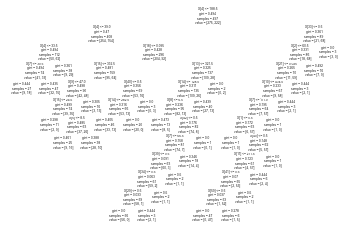

<Figure size 1440x1440 with 0 Axes>

In [17]:
#from sklearn.datasets import load_iris
from sklearn import tree
import matplotlib.pyplot as plt

X, y = df[features] , df[target]
clf = tree.DecisionTreeClassifier(min_samples_split=50)
clf = clf.fit(X, y)
tree.plot_tree(clf) 
plt.figure(figsize=(20,20))

In [18]:
selected_features=['n_accidents_in_0.006', 'days_last_accident','freq_extra_one_month', 'freq_extra_two_month','days_pick_start', 
        'days_excused', 'days_vacation', 'days_employment', 'freq_absence_one_month', 'freq_absence_two_month']

In [19]:
df_raw[selected_features+['AccPreventable']].groupby(selected_features).mean()

AccPreventable
n_accidents_in_0.006 days_last_accident freq_extra_one_month freq_extra_two_month days_pick_start days_excused days_vacation days_employment freq_absence_one_month freq_absence_two_month                
0                    -1.0               0.0                  0.0                  88.0             49.0         54.0         606             0.00                   0.13                                 0
                      20.0              0.0                  0.0                  38.0             41.0         95.0         675             0.13                   0.13                                 0
1                     17.0              0.0                  0.0                  77.0             56.0         79.0         805             0.00                   0.03                                 0
3                    -1.0               0.0                  0.0                  29.0            -1.0         -1.0          100             0.00                   0.00                                 1
                      46.0              0.0                  0.0                  1.0              99.0         149.0        729             0.00                   0.00                                 0
...                                                                                                                                                                                                    ...
234                   140.0             0.0                  0.0                  4.0              17.0         47.0         816             0.03                   0.15                                 0
                      187.0             0.0                  0.0                  57.0            -1.0         -1.0          187             0.00                   0.00                                 1
                      296.0             0.0                  0.0                  41.0             13.0        -1.0          614             0.07                   0.03                                 1
                      441.0             0.0                  0.0                  57.0             5.0          9.0          505             0.33                   0.33                                 1
                      483.0             0.0                  0.0                  74.0             9.0          12.0         711             0.47                   0.23                                 1

[494 rows x 1 columns]

In [20]:
df_raw['vehbusno'].unique()

array([ 753, 1321,  735,  728,  706,  770,  513, 1316,  704, 1315,  511,
        725,  516,  758,  548, 1328,  738,  501, 1291,  505,  763,  916,
       1312, 1325,  540,  372, 1409, 1402,  530,  772,  917,  805,  524,
        701,  386,  514,  912,  535,  541, 1304,  904,  527,  769,  901,
       1313,  920, 1601,  918, 1602,  771, 1412, 1318,  721, 1406,  722,
       1604,  370, 1333,  381,  515, 1329,  908, 1605,  367, 1332,  532,
        526, 1417,  756,  914,  751,  902, 1621,  525,  512, 1611, 1311,
       1410, 1619, 1323, 1408,  377, 1309,  760,  384,  752, 1405, 1617,
        544,  508, 1302,  759,  905, 1331,  724, 1416,  549,  374,  369,
        383, 1310, 1319,  503,  542, 1403,  364,  755, 1607, 1303,  913,
        371,  523, 1612,  389,  906,  765, 1327,  723,  726, 1314, 1320,
       1616,  504,  385,  506,  509,  519,  521,  361, 1418, 1419,  762,
       1610,  362,  731,  390,  522, 1413, 1330,  373, 1305, 1613, 1324,
       1415,  376,  533,  378,  528,  380, 1306, 16

<Figure size 1440x1440 with 0 Axes>

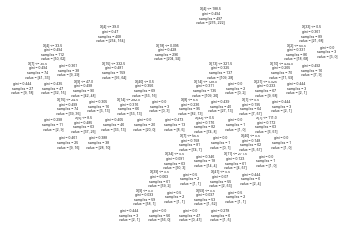

<Figure size 1440x1440 with 0 Axes>

In [21]:
#from sklearn.datasets import load_iris
from sklearn import tree
import matplotlib.pyplot as plt

X, y = df[features] , df[target]
clf = tree.DecisionTreeClassifier(min_samples_split=50)
clf = clf.fit(X, y)
tree.plot_tree(clf) 
plt.figure(figsize=(20,20))

In [22]:
features_importance=pd.DataFrame(features)
features_importance['importance']=list(clf.feature_importances_.reshape(-1,))
features_importance=features_importance.sort_values('importance',ascending=False)
bn_features=list(features_importance[features_importance['importance']>0][0])
bn_features.remove('n_accidents_in_0.003')
bn_features.remove('n_accidents_in_0.006')
bn_features.remove('Longitude')
#bn_features.remove('Latitude')
bn_features.remove('n_accidents_in_0.0005')
print(bn_features)
#bn_features=set([i.split('__')[0] for i in bn_features])

ValueError: list.remove(x): x not in list

In [ ]:
class BayesianNode:
    def __init__(self, name=None):
        self.parents=[]
        self.children=[]
        self.connectTo={}
    
    def __insert
class BayesianNetwork:
    def __init__(self, features=None):
        self.features=features
        self.nodes=[]
        

In [ ]:
print(bn_features)
bn_cat=['Neighborhood', 'Roadway','RoadwayLightConditions', 'RoadwayWeather', 'SpeedLimitCategory']
bn_num=[i for i in bn_features if i not in bn_cat]
bn_num

In [ ]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
df_raw.groupby(bn_cat).agg({target:['mean','count']})

In [ ]:
clf.tree_
n_nodes = clf.tree_.node_count
children_left = clf.tree_.children_left
children_right = clf.tree_.children_right
feature = clf.tree_.feature
threshold = clf.tree_.threshold
clf.tree_#threshold[2]

In [ ]:
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None, feature_names=features,filled=True, rounded=True)  
graph = graphviz.Source(dot_data)  
graph 